# GEE Library Overview

Writing this guide resulted in a small collection of useful high-level helper functions that make using Google Earth Engine simpler. This notebook goes over some of them.

In [3]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc
import numpy as np

import pprint as pp
import ee
ee.Initialize()

from gee_library import *

import pprint as pp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## date_slices

Dealing with imagery from different times can be difficult. Since different images were taken on different days and mosaics can be stiched together from images taken at different times, you usually need to select images taken on a *range* of dates to stich together an entire area. If you want to see an area change over time you have to select different date ranges that 1) provide 100% coverage of the area of interest and 2) do not overlap, since then you would be comparing two mosaics possibly made up of the same images.

The `date_slices` method trys to help out by finding all the dates available for the images in a cetain area and then finds non-overlapping date ranges that result in 100% coverage of the area of interest. The result is a list of date ranges.

The mechanism that this function uses is rather server-intensive and slow. This method should really only be used in the exploratory phase of a project.

Getting date slices...
34
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
Done. 8 slices found. Getting imagery...
2003-06-16 2004-06-29
1279


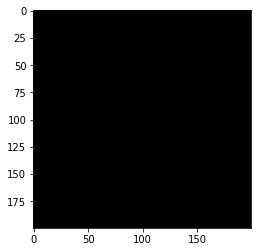

2005-06-21 2005-06-22
2


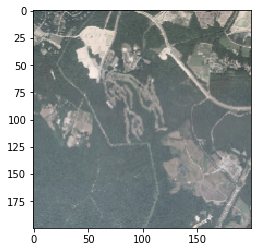

2006-06-07 2006-06-08
2


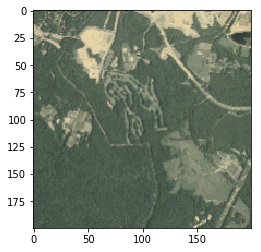

2007-07-27 2007-07-28
2


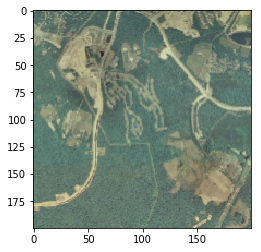

2009-06-25 2009-06-26
2


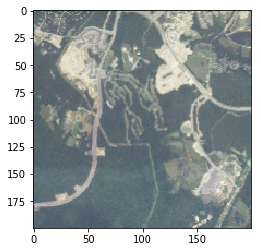

2011-06-29 2011-06-30
2


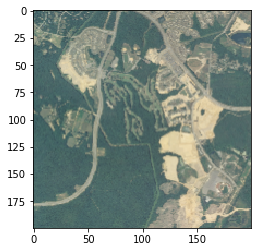

2013-09-15 2013-09-16
2


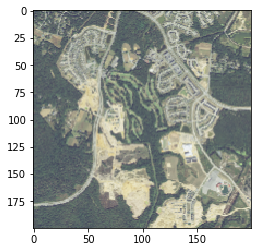

2015-08-14 2015-08-15
2


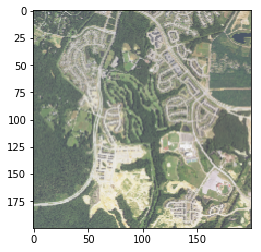

In [4]:
SAR_dataset = ee.ImageCollection('NOAA/DMSP-OLS/NIGHTTIME_LIGHTS')
SAR_dataset = ee.ImageCollection('USDA/NAIP/DOQQ')

meters = 3000
pixels = 200
resolution = meters/pixels


nps_center = [ -121.873925, 36.596853]
laplata = [-76.915988, 38.571057]
tile_bounds = square_centered_at(
    point = laplata,
    half_distance = meters/2
)


monterey_SAR_Collection = SAR_dataset.filterBounds(tile_bounds)



print "Getting date slices..."
date_slice_list = date_slices(monterey_SAR_Collection.select(['R', 'G', 'B']), tile_bounds)


print "Done.", len(date_slice_list), "slices found. Getting imagery for each slice..."
for start_date, end_date in date_slice_list:
    
    print timestamp_to_datetime(start_date.getInfo()['value']), "through", timestamp_to_datetime(end_date.getInfo()['value']),":"
    
    filtered_collection = monterey_SAR_Collection.filter(ee.Filter.date(start_date, end_date))

    # Request imagery
    tiles = img_at_region(geCollection=filtered_collection,
                          resolution=resolution,
                          bands=['R', 'G', 'B'],
                          geo_bounds=tile_bounds)
    # resize img to requested size
    np_band_array = [scipy.misc.imresize(tiles[b], (pixels, pixels)) for b in ['R', 'G', 'B']]
    
    # and stack the images in a matrix
    img = np.dstack(np_band_array)
    
    # Display the image
    plt.imshow(img); plt.show()
